In [ ]:
# default_exp data.procs

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *

# Data.Procs

In [ ]:
# export
from fastseq.data.external import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.all import *
from typing import List
import orjson

In [ ]:
# export
class CatProc():
    def __init__(self, path, num_of_workers = None, vocab = None, o2i = None):
        if vocab is None and o2i is None:
            vocab, o2i = make_vocab(path)
        self.meta = get_meta(path)
        self.f = CatMultiTfm(vocab = vocab, o2i = o2i)
        self.num_of_workers = num_of_workers
        
    def __call__(self, files:List[Path]):  
        return multithread_f(self._setup, files, self.num_of_workers)
#         r = []
#         for f in files:
#             r.append(self._setup(f))
#         return r
    
    def _setup(self, f:Path):   
        ts = get_ts_datapoint(f)
        tsm = json2TSMulti(ts, 0, self.meta['col_names']['ts_con_names'][0], ts['_length']-1, 1, self.meta)
        tsm = self.f(tsm)  
        for i, cat in enumerate(ts['ts_cat']):
            test_eq(len(tsm[2][i]), len(ts['ts_cat'][cat]))
            ts['ts_cat'][cat] = [o.item() for o in tsm[2][i]]
        for i, cat in enumerate(ts['cat']):
            ts['cat'][cat] = tsm[3][i].item()
        open(f,'wb').write(orjson.dumps(dict(ts)))
        return f
        

In [ ]:
%%time
path = Path('../data/test_data')
horizon,lookback = 7, 14
del_create([2000]*10, path = path)

fs = get_files(path, extensions='.json', folders = False)

proc = CatProc(path, num_of_workers = 1)
r = proc(fs)

CPU times: user 655 ms, sys: 3.09 ms, total: 658 ms
Wall time: 657 ms


In [ ]:
for f in fs:
    ts = get_ts_datapoint(f)
    for cat in set(unpack_list([v for k,v in ts['ts_cat'].items()])):
        test_eq(type(cat), int)
        
    for cat in set(unpack_list([v for k,v in ts['cat'].items()])):
        test_eq(type(cat), int)

In [ ]:
%%time
# hide
path = Path('../data/test_data')
horizon,lookback = 7, 14
del_create([2000]*10, path = path)

fs = get_files(path, extensions='.json', folders = False)

proc = CatProc(path, num_of_workers = 8)
r = proc(fs)

CPU times: user 915 ms, sys: 185 ms, total: 1.1 s
Wall time: 884 ms


## M5 example

In [ ]:
path = Path('../data/m5_tiny/rows')
path.ls()

(#143) [Path('../data/m5_tiny/rows/WI_1_FOODS_3_022.json'),Path('../data/m5_tiny/rows/WI_1_FOODS_3_021.json'),Path('../data/m5_tiny/rows/CA_1_HOUSEHOLD_2_511.json'),Path('../data/m5_tiny/rows/TX_1_FOODS_3_024.json'),Path('../data/m5_tiny/rows/WI_1_HOUSEHOLD_2_510.json'),Path('../data/m5_tiny/rows/WI_1_HOUSEHOLD_2_514.json'),Path('../data/m5_tiny/rows/CA_1_FOODS_2_350.json'),Path('../data/m5_tiny/rows/CA_1_FOODS_3_028.json'),Path('../data/m5_tiny/rows/CA_1_FOODS_3_020.json'),Path('../data/m5_tiny/rows/CA_1_FOODS_3_025.json')...]

In [ ]:
tmf = CatProc(path)
tmf.f.f.vocab

{'cat_id': (#3) ['FOODS','HOBBIES','HOUSEHOLD'],
 'd.1': (#1969) ['d_1','d_10','d_100','d_1000','d_1001','d_1002','d_1003','d_1004','d_1005','d_1006'...],
 'date': (#1969) ['2011-01-29','2011-01-30','2011-01-31','2011-02-01','2011-02-02','2011-02-03','2011-02-04','2011-02-05','2011-02-06','2011-02-07'...],
 'dept_id': (#7) ['FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1','HOUSEHOLD_2'],
 'id': (#30490) ['FOODS_1_001_CA_1_validation','FOODS_1_001_CA_2_validation','FOODS_1_001_CA_3_validation','FOODS_1_001_CA_4_validation','FOODS_1_001_TX_1_validation','FOODS_1_001_TX_2_validation','FOODS_1_001_TX_3_validation','FOODS_1_001_WI_1_validation','FOODS_1_001_WI_2_validation','FOODS_1_001_WI_3_validation'...],
 'item_id': (#3049) ['FOODS_1_001','FOODS_1_002','FOODS_1_003','FOODS_1_004','FOODS_1_005','FOODS_1_006','FOODS_1_008','FOODS_1_009','FOODS_1_010','FOODS_1_011'...],
 'state_id': (#3) ['CA','TX','WI'],
 'store_id': (#10) ['CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_

{'Train': 237084, 'Val': 7866, 'Validation': 138, 'Evaluation': 138}


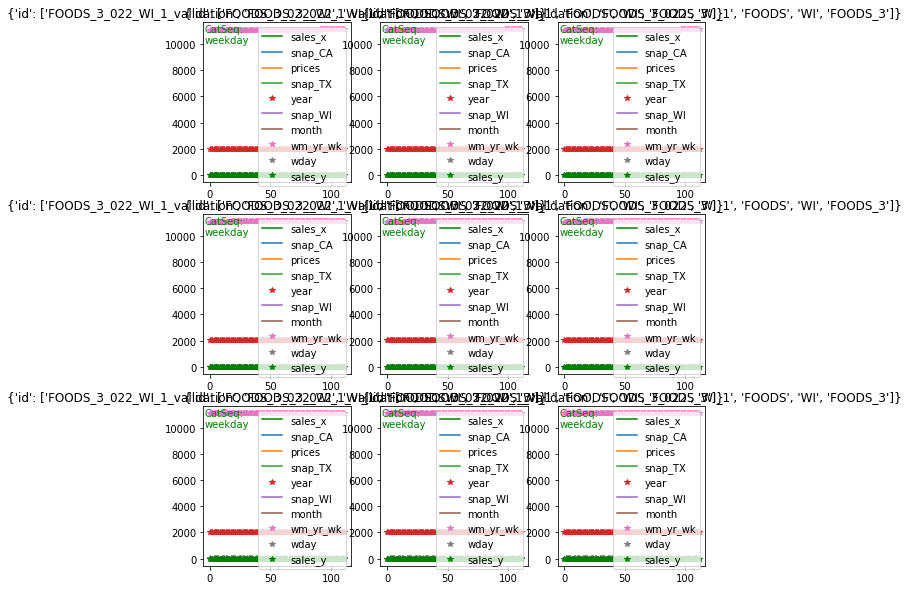

In [ ]:
horizon,lookback = 28, 28*3
dls = MTSDataLoaders.from_m5_path(path, 'sales',  horizon=horizon, lookback=lookback,)
dls.show_batch()

In [ ]:
%%time
for o in dls.train:
    pass

CPU times: user 21.6 s, sys: 3.58 s, total: 25.1 s
Wall time: 1min 21s


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [ ]:
git_add('04_data.procs.ipynb', commit_msg='CatProc')

Converted 04_data.procs.ipynb.


['/home/tako/dev/fastseq/fastseq/data/procs.py',
 '/home/tako/dev/fastseq/nbs/04_data.procs.ipynb']